<a href="https://colab.research.google.com/drive/1YS-G6DML1xq3AhlNpKmh18Dc4tkn9T4U?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


**AUTHOR OF THE NOTEBOOK : Susnato Dhar https://github.com/susnato**

**ACKNOWLEDGEMENTS AND MENTIONS**
<ul>
<li>The whole explanation about GANs can be found in the book <a href="https://probml.github.io/pml-book/book2.html">Probabilistic Machine Learning: Advanced Topics</a> by <a href="https://github.com/murphyk">Kevin P Murphy</a>. </li>
<li>I would like to thank <a href="https://github.com/valentingol">
Valentin Goldité </a>for making this awesome repository for <a href="https://github.com/valentingol/GANJax">Implementing GANs using JAX</a>.</li>
<li>I would like to thank the creators of <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> dataset.</li>

</ul>


# **INSTALL REQUIREMENTS**

In [1]:
!pip install -qq dm-haiku optax pickle5 -q

     |████████████████████████████████| 309 kB 5.4 MB/s 
     |████████████████████████████████| 136 kB 34.7 MB/s 
     |████████████████████████████████| 256 kB 11.3 MB/s 
     |████████████████████████████████| 70 kB 6.2 MB/s 


# **CLONE THE REPOSITORY**

<a href=https://github.com/valentingol/GANJax>GAN JAX</a> - A toy project to generate images from GANs with JAX

This project aims to bring the power of JAX, a Python framework developped by Google and DeepMind to train Generative Adversarial Networks for images generation.

<ul>
<li>All the credits of implementing DCGAN and ProGAN using JAX goes to the <a href=https://github.com/valentingol>author</a></li>
<li>I Took some of the examples from the repository (eg pretrained CIFAR) model and convert to a self-contained colab. as described by <a href=https://github.com/murphyk>Kevin P Murphy</a> in this <a href=https://github.com/probml/pyprobml/issues/675#issue-1140575751>thread.</a></li>
</ul>

In [2]:
%cd /content/
!git clone https://github.com/valentingol/GANJax.git
%cd /content/GANJax
%pwd

/content
Cloning into 'GANJax'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 238 (delta 42), reused 69 (delta 31), pack-reused 143
Receiving objects: 100% (238/238), 43.22 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/GANJax


'/content/GANJax'

# **IMPORTS AND CONFIGS**



In [3]:
%cd /content/GANJax

import os

try:
    import cv2
except ModuleNotFoundError:
    %pip install -qq opencv-python
    import cv2
import matplotlib.pyplot as plt

from jax import numpy as jnp, random

try:
    from gan.progan import ProGAN as GAN
except ModuleNotFoundError:
    %pip install -qq gan
    from gan.progan import ProGAN as GAN
try:
    from utils.save_and_load import save_gan
except ModuleNotFoundError:
    %pip install -qq utils
    from utils.save_and_load import save_gan

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
from gan.dcgan import DCGAN as GAN
from utils.data import load_images_celeba_64

print(tf.__version__)
print("DEVICES VISIBLE BY TF - ", tf.config.list_physical_devices())

/content/GANJax
2.8.0
DEVICES VISIBLE BY TF -  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# configs
SEED = 42
MODEL_PATH = "/content/saved_GANs/"
IMG_DIR = "/content/img_align_celeba/img_align_celeba"

# Training Configs
BATCH_SIZE = 128
EPOCHS = 1
display_step = 500
save_step = 10000
num_images = (6, 6)
plot = True
with_states = False  # save states or not
key = random.PRNGKey(SEED)

# **DATASET**

We are using the <a href=http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>CelebA Dataset</a>, 


In order to use it either we have to download it from their <a href=http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>website</a> or if we want to download the cropped version of dataset from the <a href=https://www.kaggle.com/jessicali9530/celeba-dataset>Kaggle</a>  we will need to have a Kaggle account and setup the kaggle token. 

Since I was facing some issues downloading from their Gdrive and it may not be relevant for some users to create a Kaggle Account and setup the token and Kaggle API, I uploaded the dataset to Dropbox and made it public so that everyone can use it without any setups or anything!
If you are facing any issues with this link then you can <a href=mailto:susnatodhar10@gmail.com>mail</a> me. 
  
<ul>

<li>
All rights of the dataset belong to the original authors
</li>
<li>
As mentioned on the website, the CelebA dataset is available for non-commercial research purposes only. For specifics please refer to the website.
</li>
<li>
I only used the dataset for educational purpose and if you have any objection about it, ask me I will remove it. 
</li>

</ul>

Let's Download the files from the DropBox link and extract the images.

**DOWNLOAD THE DATASET**

In [5]:
%cd /content/
!wget https://www.dropbox.com/s/eeqi3nuj2z6zxes/celebA.zip?dl=0
!unzip -qq '/content/celebA.zip?dl=0' -d '/content/'

/content
--2022-03-15 01:23:35--  https://www.dropbox.com/s/eeqi3nuj2z6zxes/celebA.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eeqi3nuj2z6zxes/celebA.zip [following]
--2022-03-15 01:23:36--  https://www.dropbox.com/s/raw/eeqi3nuj2z6zxes/celebA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65de22c3cd127a6688f0ac792f.dl.dropboxusercontent.com/cd/0/inline/BhfwDooqyBkaFGI3067LR48WdaemW93_wWuB4oH_cCi5qGTHONtJNRNcgfXU38gJg5UVqYR-RlJ6CY5z11oPJknX6axYivI_js_0AL_gHIK71zJxcFd4LvqNMGm1rIvxA6j2VmO1r6QPUnvQiA49_Zmgj8rGdKi-sO09qlBmkq-LBg/file# [following]
--2022-03-15 01:23:36--  https://uc65de22c3cd127a6688f0ac792f.dl.dropboxusercontent.com/cd/0/inline/BhfwDooqyBkaFGI3067LR48WdaemW93_wWuB4oH_cCi5qGTHONtJNRNcgfXU

**PREPARE THE DATASET**

The code in the main repository is fine and can be used without any error but it shuffles the images after creating the dataset using `tf.data.Dataset` and doing so it takes some time so I commented the line out. Feel free to use the `load_images` from `utils.data` .

In [6]:
def load_images_celeba_64_nb(batch_size=128, seed=0, path="data/CelebA/images"):
    def generate_data():
        for f_name in os.listdir(path):
            img = cv2.imread(os.path.join(path, f_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[20:-20, :, :]
            img = cv2.resize(img, (64, 64))
            img = tf.constant(img, dtype=tf.float32)
            img = (img / 255.0) * 2.0 - 1.0
            yield img

    dataset = tf.data.Dataset.from_generator(generate_data, output_types=tf.float32, output_shapes=(64, 64, 3))
    # dataset = dataset.shuffle(buffer_size=202_600, seed=seed)
    dataset = dataset.batch(batch_size).prefetch(10)
    dataset.__len__ = lambda: tf.constant(202_599 // batch_size + 1, dtype=tf.int64)
    return dataset

In [7]:
# tf.data.Dataset
dataset = load_images_celeba_64_nb(path=IMG_DIR, batch_size=BATCH_SIZE, seed=SEED)
print("Dataset loaded.")

Dataset loaded.


Let's see some images from the dataset to make sure that they are ok.


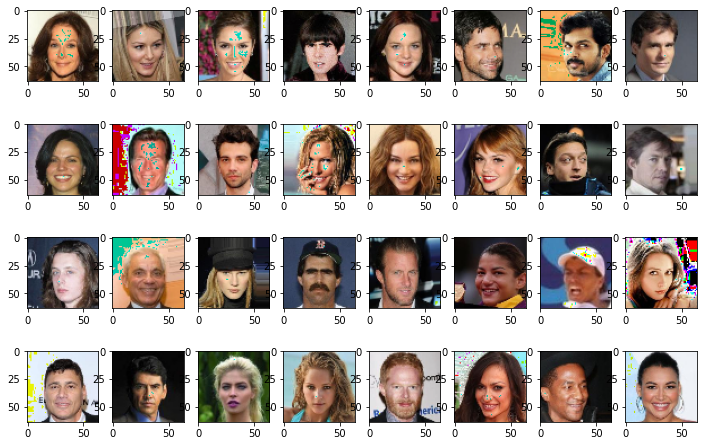

In [8]:
"""
Make sure to keep the batch_size of the dataset >= 32 in order to run this properly 
"""
import numpy as np

for i_ in dataset.take(1):
    fig, ax = plt.subplots(4, 8, figsize=(12, 8))
    r_, c_ = 0, 0
    for ei_ in i_:
        ei_ = np.array(ei_)
        im = (ei_ - np.max(ei_)) / (np.max(ei_) - np.min(ei_))  # normalize 0..1
        ax[r_, c_].imshow((im * 255).astype(np.uint8))
        c_ += 1
        if c_ >= 8:
            r_ += 1
            c_ = 0
        if r_ >= 4:
            break

# **MODEL**

We are using a ProGAN(PROGRESSIVE GROWING OF GANs)

**MODEL TRAINING AND TESTING**

Let's try to get some initial results quickly using the Pre-Trained Model, then we will go to the training part


**MODEL TESTING**

In [9]:
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq dm-haiku
    import haiku as hk
try:
    import pickle5 as pickle
except ModuleNotFoundError:
    %pip install -qq pickle5
    import pickle5 as pickle


def load_jax_model(model_path):
    param_path = os.path.join(model_path, "params", "params.pickle")
    state_path = os.path.join(model_path, "state", "state.pickle")
    with open(param_path, "rb") as handle:
        params = pickle.load(handle)
    if os.path.exists(state_path):
        with open(state_path, "rb") as handle:
            state = pickle.load(handle)
        return params, state
    else:
        return params


@hk.transform_with_state
def generate(zseed, config, n_samples=1, is_training=False):
    zkey = random.PRNGKey(zseed)
    kwargs_gen = config.get_models_kwargs()[0]
    generator = gan.Generator(**kwargs_gen)
    z = trainer.input_func(zkey, n_samples, config.zdim)
    X_fake = generator(z, is_training=is_training)
    return X_fake


class GANConfig(object):
    def __init__(self, **kwargs):
        self.default_init()
        for k, v in kwargs.items():
            if not hasattr(self, k):
                raise ValueError(f"Error in configs initialization: {k} " "is not a valid argument.")
            setattr(self, k, v)

    def default_init(self):
        """Initialize default values for all attributes.

        self.att1 = default_val1
        self.att2 = default val2
        ...

        Warning: you should define a default value for ALL valid attributes.
        """
        raise NotImplementedError("You must overload default_init.")

    def get_models_kwargs(self):
        """Return intitialization kwargs for generator
        and discriminator (parameters of __init__).
        See hk.data_structures.to_immutable_dict (or to_mutable_dict)
        to transform a dict to a (immutable or mutable) haiku dict.

        Returns:
            kwargs_gen: haiku dict
            kwargs_disc: haiku dict
        """
        raise NotImplementedError("You must overload get_models_kwargs.")

    def get_configs(self):
        configs = {}
        for attr in self.__dict__:
            if not attr.startswith("_"):
                configs[attr] = getattr(self, attr)
        return configs

    def save(self, path, verbose=True):
        configs = self.get_configs()
        head = os.path.split(path)[0]
        os.makedirs(head, exist_ok=True)
        with open(path, "wb") as handle:
            pickle.dump(configs, handle, protocol=pickle.HIGHEST_PROTOCOL)
        if verbose:
            print(f"Config saved at '{path}'.")

    def load(self, path):
        with open(path, "rb") as handle:
            configs = pickle.load(handle)
        for attr, value in configs.items():
            setattr(self, attr, value)
        return self


class DCGANConfig(GANConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def default_init(self):
        """Overwrite the default_init to define the
        configs for the DCGAN."""
        # General
        self.cylce_train_disc = 5

        # Latent input vector
        self.zdim = 64

        # Generator
        self.channels_gen = (256, 128, 64, 1)
        self.ker_shapes_gen = (3, 4, 3, 4)
        self.strides_gen = (2, 1, 2, 2)
        self.padding_gen = (0, 0, 0, 0)
        self.name_gen = "DCGAN_gen"
        self.lr_gen = 1e-4
        self.beta1_gen = 0.5
        self.beta2_gen = 0.999

        # Discriminator
        self.channels_disc = (16, 32, 1)
        self.ker_shapes_disc = 4
        self.strides_disc = 2
        self.padding_disc = (0, 0, 0, 0)
        self.name_disc = "DCGAN_disc"
        self.lr_disc = 1e-4
        self.beta1_disc = 0.5
        self.beta2_disc = 0.999

    def get_models_kwargs(self):
        """Overwrite the get_models_kwargs to get the
        configs required to init the modules of DCGAN."""
        kwargs_gen = {
            "channels": self.channels_gen,
            "ker_shapes": self.ker_shapes_gen,
            "strides": self.strides_gen,
            "padding": self.padding_gen,
            "name": self.name_gen,
        }
        kwargs_disc = {
            "channels": self.channels_disc,
            "ker_shapes": self.ker_shapes_disc,
            "strides": self.strides_disc,
            "padding": self.padding_disc,
            "name": self.name_disc,
        }
        kwargs_gen = hk.data_structures.to_immutable_dict(kwargs_gen)
        kwargs_disc = hk.data_structures.to_immutable_dict(kwargs_disc)
        return kwargs_gen, kwargs_disc

**TEST THE PRE-TRAINED MODEL**

We are very thankful to the author of the repository since he has provided pretrained DCGAN models on `CIFAR-10`, `CelebA` and `MNIST `datasets


Generated Images by the pre-trained model: 


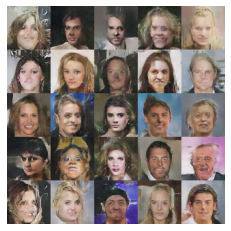

In [10]:
try:
    from gan.dcgan import DCGAN as GAN
except ModuleNotFoundError:
    %pip install -qq gan
    from gan.dcgan import DCGAN as GAN
try:
    from utils.plot_img import plot_tensor_images
except ModuleNotFoundError:
    %pip install -qq utils
    from utils.plot_img import plot_tensor_images

dataset_name = "CelebA-64"
assert dataset_name in ["CIFAR-10", "CelebA-64", "MNIST"]

pretrained_model_path = f"/content/GANJax/pre_trained/{dataset_name}/dcgan"
num_images = (5, 5)
cmap = "gray"

gan = GAN()
trainer = gan.Trainer()

config = DCGANConfig().load(os.path.join(pretrained_model_path, "config.pickle"))
params, state = load_jax_model(os.path.join(pretrained_model_path, "generator"))

generate.init(zseed=SEED, config=config, n_samples=1, is_training=True, rng=0)

images, _ = generate.apply(
    params, state, key, zseed=SEED, config=config, n_samples=num_images[0] * num_images[1], is_training=False
)
print("Generated Images by the pre-trained model: ")
plot_tensor_images(images, num_images=num_images, cmap=cmap)
plt.show()

**MODEL TRAINING**

In order to train the model just define the `trainer` first then define the `config` then start training using `trainer.main`.

At first the predictons are only noise and later it will start making sense but since Colab does not allow us to train the model for very long time we are just training for 10 epochs.

If you want to train the model then you might need a GPU on your local machine or the training time will be enormous, if you don't have a GPU then you can use <a href="https://www.kaggle.com/">Kaggle</a>, it gives you almost 35 hours of GPU runtime per week for free(You can run each notebook upto 10 hours)!
<ol> 
<li>Download this notebook.</li>
<li>Then create a notebook in kaggle and change the Accelerator to GPU.</li>
<li>The Upload the notebook to Kaggle and run it in and don't forget to increase the EPOCHS.</li>
</ol>

/content/GANJax
Initialization succeeded.
Iteration 0, resolution 8x8
-> Growing phase
 Epoch 1/2


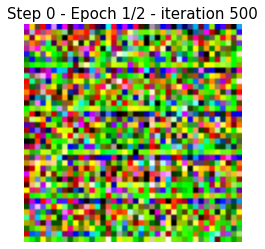

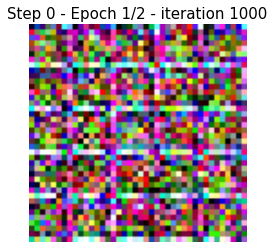

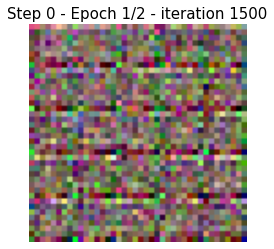


-> Fixed phase
 Epoch 2/2


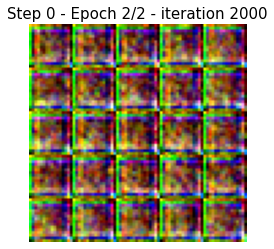

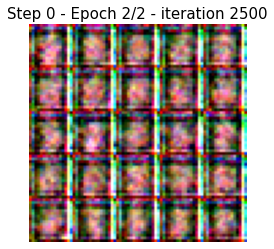

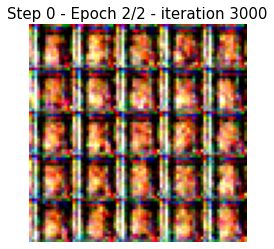

   batch 1583/1583 - gen loss: 0.39333 - disc loss: 8.52425 - time: 0h 21min 56sec - eta: 0h 0min 0sec    


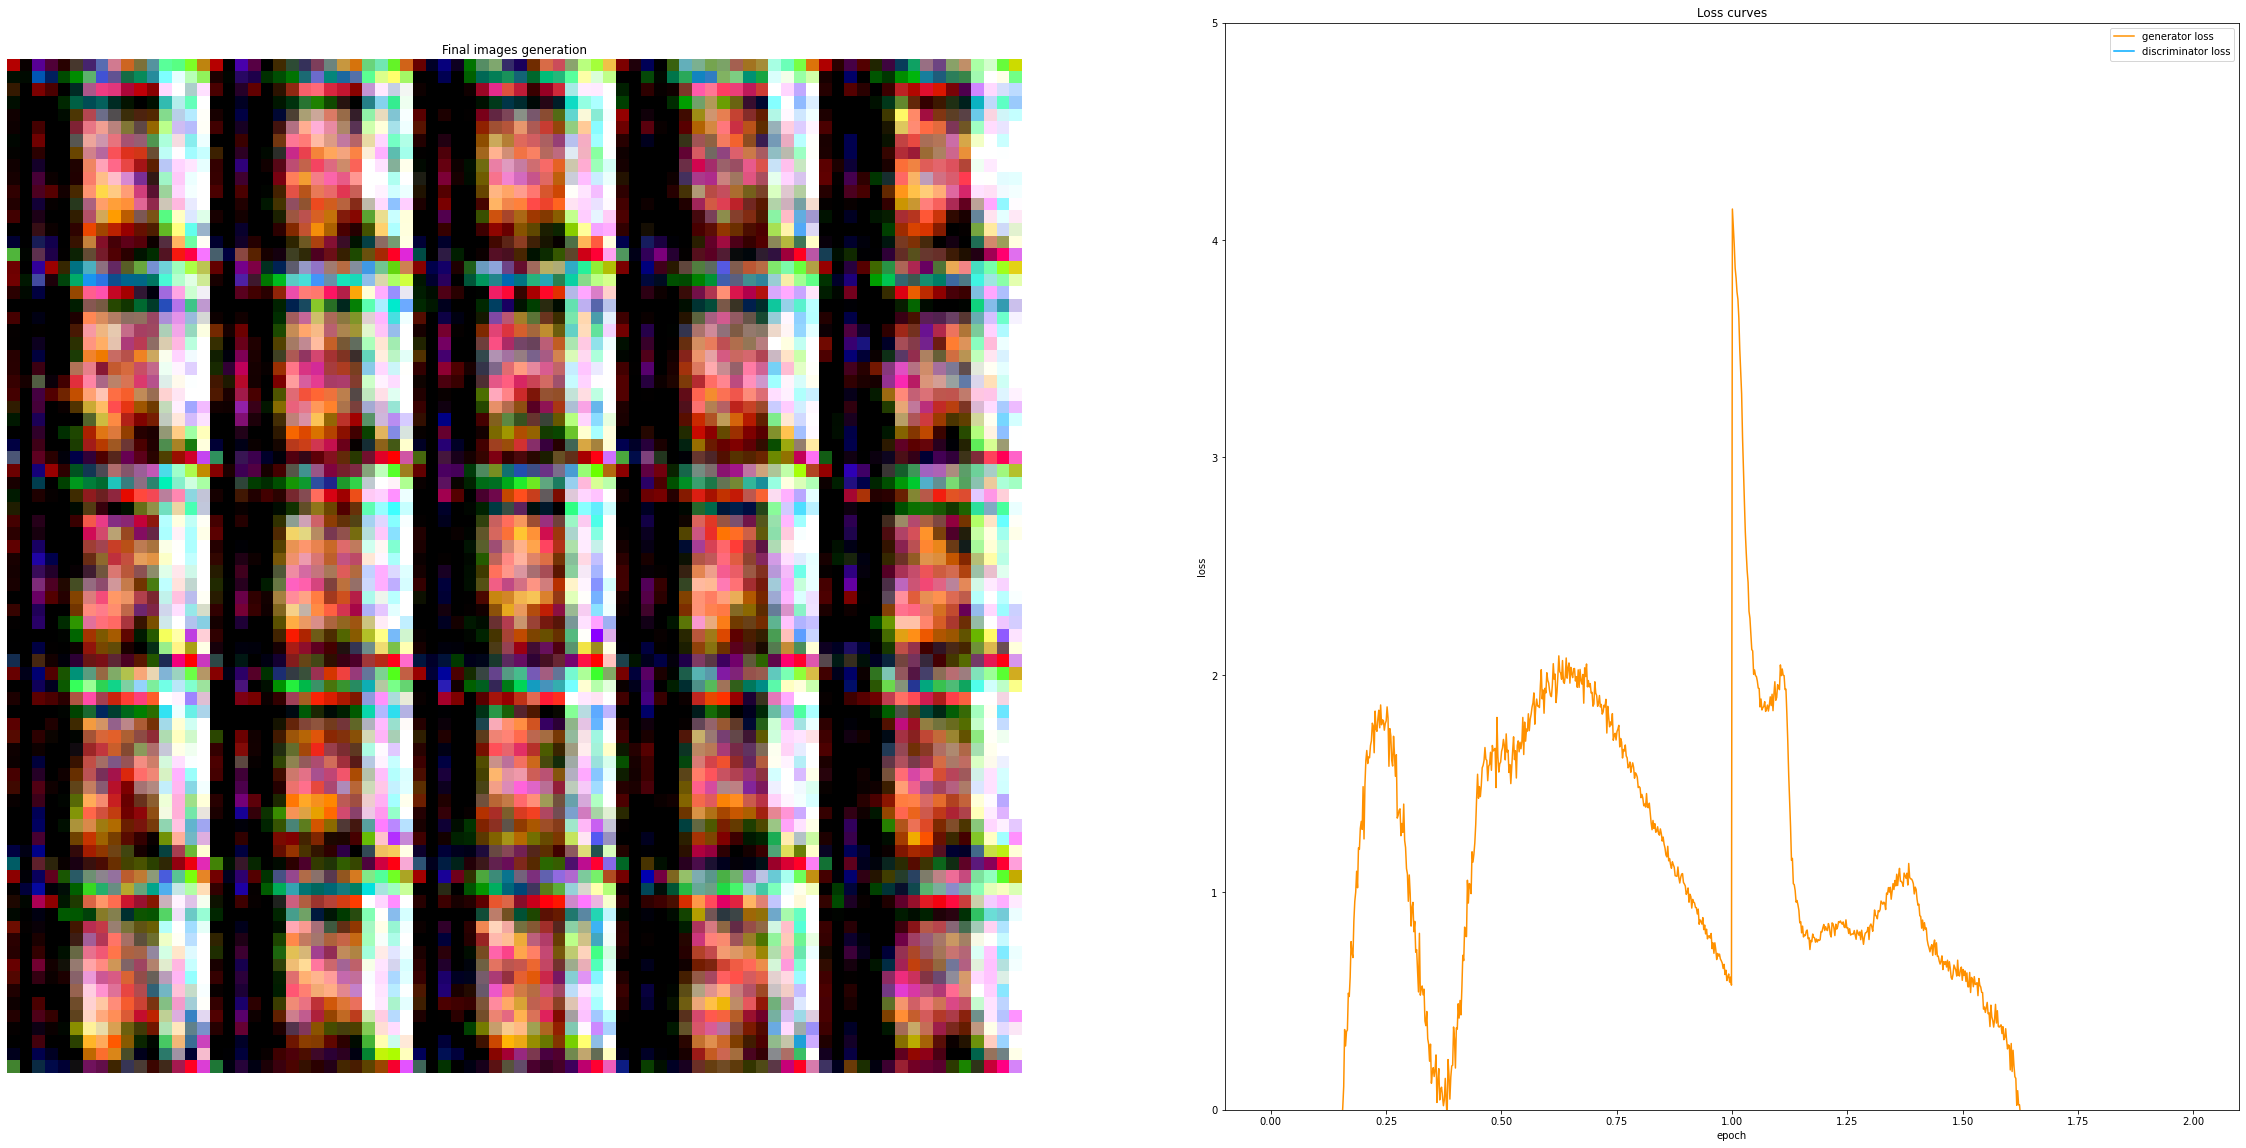

Model saved at '/content/saved_GANs/generator'.
Model saved at '/content/saved_GANs/discriminator'.
Config saved at '/content/saved_GANs/config.pickle'.


In [11]:
%cd /content/GANJax

from jax import numpy as jnp, random

try:
    from gan.progan import ProGAN as GAN
except ModuleNotFoundError:
    %pip install -qq gan
    from gan.progan import ProGAN as GAN
try:
    from utils.save_and_load import save_gan
except ModuleNotFoundError:
    %pip install -qq utils
    from utils.save_and_load import save_gan

gan = GAN()
trainer = gan.Trainer()

# DCGAN configs
config = gan.Config(
    zdim=64,
    channels_gen=64,
    channels_disc=64,
    first_resolution=8,
    n_steps=1,
    growing_epochs=(EPOCHS,),
    fixed_epochs=(EPOCHS,),
    cylce_train_disc=2,
    lr_gen=1e-5,
    lr_disc=1e-6,
    lambda_gp=10,
)
# Fit
params_gen, state_gen, params_disc, state_disc, history = trainer.main(
    dataset=dataset,
    key=key,
    config=config,
    max_time=None,
    display_step=display_step,
    num_images=num_images,
    plot=plot,
    model_path=MODEL_PATH,
    save_step=save_step,
)
"""
Save The Trained Model:

After you have trained you can save it to the `MODEL_PATH` defined in the configs section, 
be aware that if somehow the model training is interrupted then you wont be albe to save your model 
so its better to save the state after some iterations by changing this `save_step`.
"""
save_gan(params_gen, state_gen, params_disc, state_disc, config, model_path=MODEL_PATH, with_states=with_states)

**CONCLUSION**

<ul>
<li>
We see that the predicted outputs(using the pretrained model) are pretty good but they are still distorted, In order to overcome issue we can try to train it for hundreads of epochs since the dataset is very large, any data related problem won't arise.</li>
<li>
If you have made it to the end of the notebook without any error then congrats! and thanks for reading the notebook! 
</li>
<li>
If you have any comments on how to improve the notebook then please write them into comments.

</ul>

**REFERENCES**
<ul>

<li>https://probml.github.io/pml-book/book2.html</li>
<li>http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html</li>
<li>https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/</li>
<li>https://github.com/valentingol/GANJax.git</li>
</ul>